#CONEXIÓN Y LECTURA BD

## Conexión BD

In [1]:
# Montar drive y crear path para sys y para directorio de trabajo

from google.colab import drive
drive.mount('/content/drive')

import sys
import os

# Define el path al directorio de trabajo actual
path = "/content/drive/My Drive/cod/analitica_salud"


sys.path.append(path) ### para importar archivo de funciones propias a través de import

os.chdir(path) ### para que por defecto suba y descargue archivos partiendo de esa ruta

Mounted at /content/drive


## Cargar Librerías

In [2]:
!pip install --quiet optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 11.2 MB/s eta 0:00:00


In [28]:
import pandas as pd
import graphviz
import optuna
import joblib

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.linear_model import LogisticRegression


##Acceso Notebook

In [4]:
salud_model= pd.read_csv('data/salud_modelado_final.csv')
salud_model.head()

,cholesterol_2,cholesterol_3,gluc_2,gluc_3,smoke,alco,active,age,height,weight,ap_hi,ap_lo,cardio
0,0,0,0,0,0,0,1,0.600000,0.600000,0.192982,0.153846,0.50,0
1,0,1,0,0,0,0,1,0.742857,0.200000,0.596491,0.615385,0.75,1
2,0,1,0,0,0,0,0,0.628571,0.500000,0.228070,0.461538,0.25,1
3,0,0,0,0,0,0,1,0.542857,0.633333,0.543860,0.769231,1.00,1
4,0,0,0,0,0,0,0,0.514286,0.200000,0.087719,0.000000,0.00,0


# Modelo

## Regresión Logística

In [5]:
x = salud_model.drop("cardio", axis=1)

y = salud_model["cardio"]

x_train,x_test,y_train,y_test = train_test_split(x,y,shuffle = True,test_size=0.30, random_state=123)


model = LogisticRegression() # definir el modelo
model.fit(x_train,y_train) # entrenar el modelo

y_pred_train = model.predict(x_train) # guardar la predicción para train
y_pred_test = model.predict(x_test) # guardar la predicción para test


y_pred_test # predicción de test
y_test # realidad de test

,cardio
52751,1
28203,0
42946,0
45738,0
5086,0
...,...
6471,1
21495,1
13220,1
18854,1


### Metricas de Desempeño

[[17356  4450]
 [ 7317 13301]]


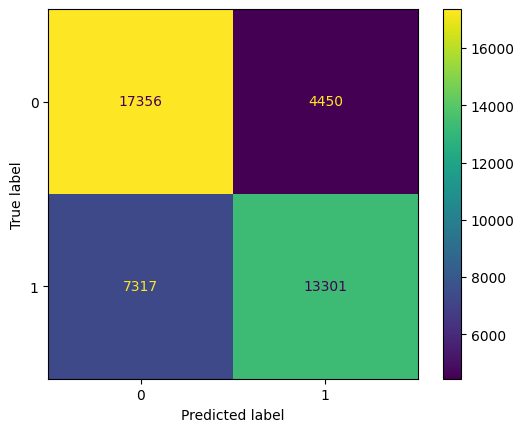

In [6]:
# metricas de entrenamiento
cm1 = confusion_matrix(y_train, y_pred_train, labels=model.classes_) # guardar las clases para la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm1,display_labels=model.classes_)
disp.plot();
print(cm1)

In [7]:
TP=cm1[1,1] # el modelo dijo que eran 1 y en la realidad son 1, verdaderos positivos - 446
FP=cm1[0,1] # el modelo dijo que eran 1, en la realidad son 0, falsos positivos - 49
FN=cm1[1,0] # el modelo dijo que eran 0, en la realidad son 1, falsos negativos - 63
TN=cm1[0,0] # el modelo dijo que eran 0 y en la realidad son 0, verdaderos negativos - 723

print(f"Accuracy train: {accuracy_score(y_train, y_pred_train)}")
print(f'Precicion: {TP/(TP+FP)}')
print(f'Recall (Sensibilidad)): {TP/(TP+FN)}')
print(f'F1-score:', f1_score(y_train, y_pred_train, average='binary'))
print(f'Especificidad: {TN/(FP+TN)}')

Accuracy train: 0.722633415048086
Precicion: 0.7493098980339136
Recall (Sensibilidad)): 0.6451159181297895
F1-score: 0.6933201282285179
Especificidad: 0.7959277263138586


[[7284 1906]
 [3182 5811]]


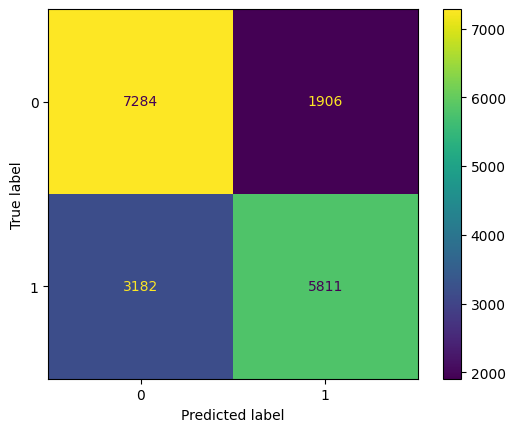

In [8]:
# Matriz de confusión:
cm = confusion_matrix(y_test, y_pred_test, labels=model.classes_) # guardar las clases para la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot();
print(cm)

In [9]:
#metricas de testeo
TP=cm[1,1] # el modelo dijo que eran 1 y en la realidad son 1, verdaderos positivos - 446
FP=cm[0,1] # el modelo dijo que eran 1, en la realidad son 0, falsos positivos - 49
FN=cm[1,0] # el modelo dijo que eran 0, en la realidad son 1, falsos negativos - 63
TN=cm[0,0] # el modelo dijo que eran 0 y en la realidad son 0, verdaderos negativos - 723

print(f"Accuracy test: {accuracy_score(y_test, y_pred_test)}")
print(f'Precicion: {TP/(TP+FP)}')
print(f'Recall (Sensibilidad)): {TP/(TP+FN)}')
print(f'F1-score:', f1_score(y_test, y_pred_test, average='binary'))
print(f'Especificidad: {TN/(FP+TN)}')

Accuracy test: 0.7201781884177528
Precicion: 0.7530128288194894
Recall (Sensibilidad)): 0.6461692427443567
F1-score: 0.6955116696588869
Especificidad: 0.7926006528835691


## Árbol de Decisión

In [10]:
salud_arbol=salud_model.copy()
salud_arbol.head()

,cholesterol_2,cholesterol_3,gluc_2,gluc_3,smoke,alco,active,age,height,weight,ap_hi,ap_lo,cardio
0,0,0,0,0,0,0,1,0.600000,0.600000,0.192982,0.153846,0.50,0
1,0,1,0,0,0,0,1,0.742857,0.200000,0.596491,0.615385,0.75,1
2,0,1,0,0,0,0,0,0.628571,0.500000,0.228070,0.461538,0.25,1
3,0,0,0,0,0,0,1,0.542857,0.633333,0.543860,0.769231,1.00,1
4,0,0,0,0,0,0,0,0.514286,0.200000,0.087719,0.000000,0.00,0


In [15]:

# dividir en independientes y dependiente
X, y = salud_arbol.drop('cardio', axis = 1), salud_arbol['cardio']

# definir modelo
clf = tree.DecisionTreeClassifier(max_depth=10, random_state=123) #, class_weight='balanced', #
# dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 123, test_size= 0.3)

# entrenar modelo
clf = clf.fit(X_train, y_train)

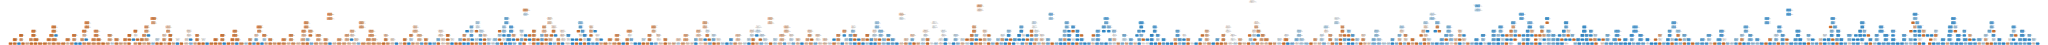

In [16]:
# Convertir los valores únicos de y a cadenas
class_names = [str(cls) for cls in y.unique()]

# Generar el gráfico

dot_data = tree.export_graphviz(clf,
                                feature_names=X.columns,  # Cambiado a X.columns
                                class_names=class_names,  # Cambiado a la lista de clases
                                filled=True, rounded=True,
                                special_characters=True)

graph = graphviz.Source(dot_data)
graph

### Métricas de Desempeño

In [17]:
# hacer la predicción sobre train
clf = clf.fit(X_train, y_train)
y_true = clf.predict(X_train)
print(metrics.classification_report(y_train, y_true, digits = 3))

              precision    recall  f1-score   support

           0      0.728     0.812     0.768     21806
           1      0.774     0.679     0.723     20618

    accuracy                          0.748     42424
   macro avg      0.751     0.746     0.746     42424
weighted avg      0.750     0.748     0.746     42424



In [18]:
# hacer la predicción sobre test
clf = clf.fit(X_train, y_train)
y_true = clf.predict(X_test)
print(metrics.classification_report(y_test, y_true, digits = 3))

              precision    recall  f1-score   support

           0      0.696     0.785     0.738      9190
           1      0.748     0.650     0.695      8993

    accuracy                          0.718     18183
   macro avg      0.722     0.718     0.717     18183
weighted avg      0.722     0.718     0.717     18183



## Bosque Aleatorio

In [19]:
salud_forest=salud_model.copy()
salud_forest.head()

,cholesterol_2,cholesterol_3,gluc_2,gluc_3,smoke,alco,active,age,height,weight,ap_hi,ap_lo,cardio
0,0,0,0,0,0,0,1,0.600000,0.600000,0.192982,0.153846,0.50,0
1,0,1,0,0,0,0,1,0.742857,0.200000,0.596491,0.615385,0.75,1
2,0,1,0,0,0,0,0,0.628571,0.500000,0.228070,0.461538,0.25,1
3,0,0,0,0,0,0,1,0.542857,0.633333,0.543860,0.769231,1.00,1
4,0,0,0,0,0,0,0,0.514286,0.200000,0.087719,0.000000,0.00,0


In [20]:
X, y = salud_forest.drop('cardio', axis = 1), salud_arbol['cardio']

In [21]:
# Crear el modelo
model = RandomForestClassifier(n_estimators=150,  # número de árboles
                               criterion='gini',
                               max_depth=10,  # estrategia de parada
                               min_samples_leaf=5,
                               max_features=None,
                               oob_score=False,
                               n_jobs=-1,
                               random_state=123)

# Entrenar el modelo
model.fit(X_train, y_train)


RandomForestClassifier(max_depth=10, max_features=None, min_samples_leaf=5,
                       n_estimators=150, n_jobs=-1, random_state=123)

### Métricas de Desempeño

In [22]:
# Calcular y mostrar las métricas en el conjunto de entrenamiento
print(metrics.classification_report(y_train, model.predict(X_train)))

              precision    recall  f1-score   support

           0       0.73      0.81      0.77     21806
           1       0.77      0.69      0.73     20618

    accuracy                           0.75     42424
   macro avg       0.75      0.75      0.75     42424
weighted avg       0.75      0.75      0.75     42424



In [23]:
# Calcular y mostrar las métricas en el conjunto de prueba
print(metrics.classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.71      0.79      0.74      9190
           1       0.75      0.67      0.71      8993

    accuracy                           0.73     18183
   macro avg       0.73      0.73      0.73     18183
weighted avg       0.73      0.73      0.73     18183



# Optimización de Hiperparámetros

Se selecciona el modelo de bosque aleatorio para optimización de hiperparámetros

In [26]:

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 200),
        "max_depth": trial.suggest_int("max_depth", 5, 20),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5)
    }

    model = RandomForestClassifier(**params, random_state=123)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring="f1").mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)


[I 2025-06-06 03:36:06,897] A new study created in memory with name: no-name-78eec946-6496-4dbf-8dfe-8f1cd70a061b
[I 2025-06-06 03:36:19,011] Trial 0 finished with value: 0.7048493000260366 and parameters: {'n_estimators': 129, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 6}. Best is trial 0 with value: 0.7048493000260366.
[I 2025-06-06 03:36:23,259] Trial 1 finished with value: 0.7042130627536382 and parameters: {'n_estimators': 70, 'max_depth': 22, 'max_features': 'log2', 'min_samples_leaf': 8}. Best is trial 0 with value: 0.7048493000260366.
[I 2025-06-06 03:36:34,436] Trial 2 finished with value: 0.7035894128661994 and parameters: {'n_estimators': 190, 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 4}. Best is trial 0 with value: 0.7048493000260366.
[I 2025-06-06 03:37:01,623] Trial 3 finished with value: 0.70177851699195 and parameters: {'n_estimators': 150, 'max_depth': 17, 'max_features': None, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.7

In [25]:

#Resultados
print(f"Best trial:")
print(f"  Value (Test AUC): {study.best_value:.4f}")
print(f"  Params: {study.best_params}")


Best trial:
  Value (Test AUC): 0.7049
  Params: {'n_estimators': 182, 'max_depth': 17, 'max_features': 'log2', 'min_samples_leaf': 5}


In [27]:
#Obtener los mejores parámetros
best_params = study.best_params

#Crear el modelo con esos parámetros
best_model = RandomForestClassifier(**best_params, random_state=123)

#Entrenarlo
best_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=30, min_samples_leaf=6, n_estimators=129,
                       random_state=123)

In [29]:
joblib.dump(best_model, "salidas/best_rf_optuna.pkl")

FileNotFoundError: [Errno 2] No such file or directory: 'salidas/best_rf_optuna.pkl'

#Analisis modelo ganador